<a href="https://colab.research.google.com/github/VarshaChanumolu/Red-Blood-Cell-Count-using-Deep-Learning-Image-Segmentation/blob/main/RBC%20Count%20using%20Image%20Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading The dataset

In [ ]:
#Importing drive into the notebook
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
#Set current working directory
%cd /content/gdrive/My Drive/PBL_Blood/archive (8)/

/content/gdrive/My Drive/PBL_Blood/archive (8)


In [ ]:
#Importing all required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import os.path
import cv2 as cv
import matplotlib.pyplot as plt

#Stroing images in imgdict
imagePathList = []

for dirname, _, filenames in os.walk("images"):
    for filename in filenames:
        strPath = os.path.join(dirname, filename)
        ext = os.path.splitext(filename)[1]
        if ext == '.png':
            imagePathList.append(strPath)      

#dict<filename:string, hsvImage:image>
imgDict = {os.path.basename(path): cv.cvtColor(cv.imread(path), cv.COLOR_BGR2HSV) for path in imagePathList}

In [ ]:
imgDict

{'image-1.png': array([[[ 12,  44, 203],
         [ 14,  36, 203],
         [ 20,  28, 198],
         ...,
         [171,  36, 189],
         [171,  37, 186],
         [171,  37, 188]],
 
        [[ 11,  44, 204],
         [ 14,  34, 202],
         [ 30,  17, 190],
         ...,
         [171,  29, 183],
         [168,  32, 182],
         [164,  37, 185]],
 
        [[ 13,  40, 205],
         [ 16,  33, 201],
         [ 26,  18, 193],
         ...,
         [171,  29, 184],
         [168,  32, 182],
         [166,  37, 187]],
 
        ...,
 
        [[166, 103, 181],
         [167, 105, 182],
         [168, 103, 186],
         ...,
         [ 70,  49, 222],
         [ 69,  49, 222],
         [ 70,  49, 224]],
 
        [[168,  99, 180],
         [168, 105, 178],
         [168, 104, 184],
         ...,
         [ 70,  49, 222],
         [ 69,  49, 224],
         [ 71,  51, 224]],
 
        [[168,  99, 181],
         [168,  98, 183],
         [169, 101, 187],
         ...,
         [ 71

In [ ]:
from collections import namedtuple
from collections import defaultdict
#Reading the annotations of the images into annotationdf
annotationDf = pd.read_csv("annotations.csv");
print(annotationDf.head())

#type = ['rbc'|'wbc']
CellLabel = namedtuple('CellLabel', ['left', 'top', 'right', 'bot', 'type'])

#dict<filename:string, CellLabel[]>  
imgLabelDict = defaultdict(list)

for _, row in annotationDf.iterrows():
    label = CellLabel(
        int(row['xmin']), 
        int(row['ymin']), 
        int(row['xmax']), 
        int(row['ymax']), 
        row['label'])
    imageName = row['image']
    imgLabelDict[imageName].append(label)

           image       xmin       ymin        xmax       ymax label
0  image-100.png   0.000000   0.000000   25.190198  40.816803   rbc
1  image-100.png  15.010502   0.000000   68.337223  23.527421   rbc
2  image-100.png  25.017503  16.021004   78.374562  73.735123   rbc
3  image-100.png  75.565928   1.061844  140.248541  45.591599   rbc
4  image-100.png  77.483081  23.290548  131.936989  74.806301   rbc


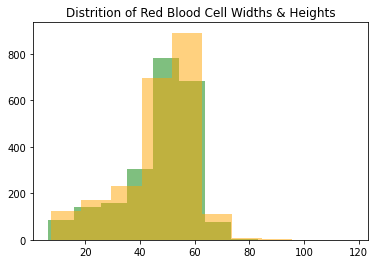

Min width:6.47 pixels, Min Height:7.49 pixels
Mean width:47.21 pixels, Min Height:46.92 pixels


In [ ]:
#Plotting distribution to check distribution of red blood cell width and height
rbcOnly = annotationDf[annotationDf["label"]=="rbc"]
rbcWidths = rbcOnly["xmax"] - rbcOnly["xmin"]
rbcHeights = rbcOnly["ymax"] - rbcOnly["ymin"]

plt.hist(rbcWidths, color="green", alpha=0.5, label="Widths")
plt.hist(rbcHeights, color="orange", alpha=0.5, label="Heights")
plt.title("Distrition of Red Blood Cell Widths & Heights")
plt.show()

print("Min width:{:.2f} pixels, Min Height:{:.2f} pixels".format(rbcWidths.min(), rbcHeights.min()))
print("Mean width:{:.2f} pixels, Min Height:{:.2f} pixels".format(rbcWidths.mean(), rbcHeights.mean()))

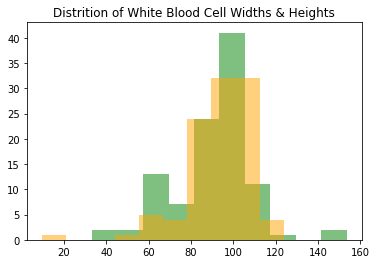

Min width:33.36 pixels, Min Height:9.67 pixels
Mean width:90.88 pixels, Min Height:93.07 pixels


In [ ]:
#Plotting white blood cell distribution if widths and heights
wbcOnly = annotationDf[annotationDf["label"]=="wbc"]
wbcWidths = wbcOnly["xmax"] - wbcOnly["xmin"]
wbcHeights = wbcOnly["ymax"] - wbcOnly["ymin"]

plt.hist(wbcWidths, color="green", alpha=0.5, label="Widths")
plt.hist(wbcHeights, color="orange", alpha=0.5, label="Heights")
plt.title("Distrition of White Blood Cell Widths & Heights")
plt.show()

print("Min width:{:.2f} pixels, Min Height:{:.2f} pixels".format(wbcWidths.min(), wbcHeights.min()))
print("Mean width:{:.2f} pixels, Min Height:{:.2f} pixels".format(wbcWidths.mean(), wbcHeights.mean()))

In [ ]:
#Train test split on input data in the ratio 70:30
from sklearn.model_selection import train_test_split
n_samples=10
testFraction =0.3
trainSampleFilenames, testSampleFilenames = train_test_split(list(imgDict.keys()),test_size=testFraction)

In [ ]:
#Making subimages onto the image by using annotations
import matplotlib.pyplot as plt

rbcSubImages = []
wbcSubImages = []
bgHistList = []

for trainFileName in trainSampleFilenames:
    hueOnly = imgDict[trainFileName][:,:,0]
    labels = imgLabelDict[trainFileName]
    bgMask = np.zeros(hueOnly.shape, np.uint8)
    bgMask.fill(255) #Initially all visible, will mask out cell regions later
    for label in labels:
        bgMask[label.top:label.bot,label.left:label.right] = 0#mask out fg (wbc or rbc)
        subImage = hueOnly[label.top:label.bot,label.left:label.right]
        if label.type == "rbc":
            rbcSubImages.append(subImage)
        else:
            wbcSubImages.append(subImage)
    bgHist = cv.calcHist([hueOnly], [0], bgMask, [181], [0, 181])
    bgHistList.append(bgHist[:,0])
            
print("(Training Set) No. of rbc:{0}, wbc:{1}".format(len(rbcSubImages), len(wbcSubImages)))

(Training Set) No. of rbc:1570, wbc:70


# Pixel Naive Bayes Classifier for Red Blood Cells

The dataset is first separated into an 70-30 train-test split.

Sub-images representing each red-blood cell (as defined by their bounding boxes) are cropped out. The background (portion of the image not marked as either a red blood cell or white blood cell) is also extracted. The mean histogram of these 2 pixel classes is then calculated, revealing each class to correspond strongly to a single hue (greenish cyan for the background & red for the RBCs). The statistical probability of each hue belonging to either class if then used to classify the pixels. The class-prior probability term is ignored for the NBC in this case.

In [ ]:
#Assigning histogram values to each class
rbcHistogram = cv.calcHist(rbcSubImages, [0] , None, [181], [0, 181])
wbcHistogram = cv.calcHist(wbcSubImages, [0] , None, [181], [0, 181])
bgHistogram = np.sum(np.array(bgHistList), axis=0)

Peak hue for BG:71, WBC:168


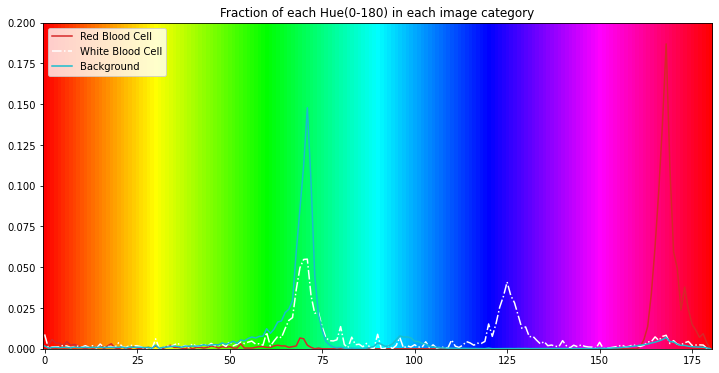

In [ ]:
#Plotting histrogram map to show different values of classes used
def normalizeHistogram(hist):
    return hist / np.sum(hist)

hsvGradient = cv.cvtColor(np.array([[[h, 255, 255] for h in np.arange(0, 181, dtype=np.uint8)]], dtype=np.uint8), cv.COLOR_HSV2RGB )

rbcPixelProb = normalizeHistogram(rbcHistogram)
wbcPixelProb = normalizeHistogram(wbcHistogram)
bgPixelProb = normalizeHistogram(bgHistogram)

plt.figure(figsize=(12,6))
plt.title("Fraction of each Hue(0-180) in each image category")
plt.imshow(hsvGradient, origin='lower',aspect='auto')
plt.gca().set_ylim(0,0.2)
plt.plot(rbcPixelProb, color="tab:red",linestyle="-", label="Red Blood Cell")
plt.plot(wbcPixelProb, color="white", linestyle="-.", label="White Blood Cell")
plt.plot(bgPixelProb, color="tab:cyan", label="Background")
plt.legend()

print("Peak hue for BG:{0}, WBC:{1}".format(np.argmax(bgPixelProb), np.argmax(rbcPixelProb)))

# Chroma-Correction on source images

Simply applying the NBC classifier that was obtained using the mean color probabilities results in poor classification for some images (i.e. second pair shown below, where most of the image is simply marked as unknown).
The poor pixel classification occurs if the color distribution of an image varies too greatly from the mean of the image set. 
Since each pixel class corresponds strongly to a single hue peak, color correction can be performed by roughly identifying the target color peak within an image and shifting it closer to the statistical mean.

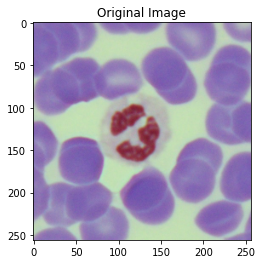

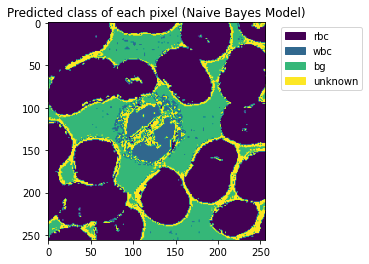

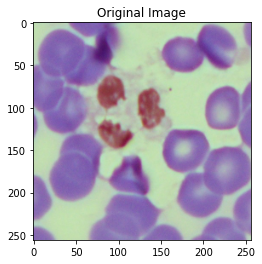

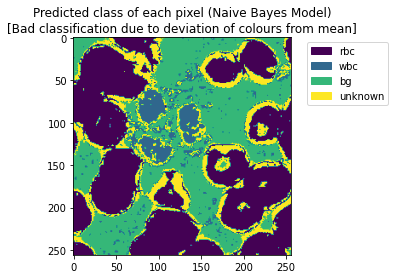

In [ ]:
#Chroma correctiom for the images for good classification
import matplotlib.patches as mpatches

#hsvImage -> np.uint8[][]
def CrudePixelClassification(hsvImage):
    (height, width, _) = hsvImage.shape
    markedArray = np.zeros((height, width), dtype=np.uint8) 
    for row in range(height):
        for col in range(width):
            pixelHue = hsvImage[row,col,0]
            probabilities = [rbcPixelProb[pixelHue], wbcPixelProb[pixelHue], bgPixelProb[pixelHue]]
            maxVal = max(probabilities)
            noiseThreshold = 0.005
            markedArray[row,col] = probabilities.index(maxVal) if maxVal > noiseThreshold else len(probabilities)
    return markedArray
            
trainImgList = [imgDict[path] for path in trainSampleFilenames]

testImg = trainImgList[1]
markedPixels = CrudePixelClassification(testImg)

def PlotMarkedPixelGraph(markedPixels, hsvImg, optionalCaption=None):
    plt.title("Original Image")
    plt.imshow(cv.cvtColor(hsvImg, cv.COLOR_HSV2BGR))
    plt.show()
    
    hMarked = plt.imshow(markedPixels)
    additionalCaption = "\n" + optionalCaption if optionalCaption != None else ""
    plt.title("Predicted class of each pixel (Naive Bayes Model)" + additionalCaption)
    colors = [ hMarked.cmap(hMarked.norm(level)) for level in range(4)]
    patches = [ mpatches.Patch(color=colors[index], label=labelName) for index,labelName in enumerate(["rbc", "wbc", "bg", "unknown"])]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2)
    plt.show()
    
PlotMarkedPixelGraph(markedPixels, testImg)

skewedColorImg = trainImgList[2]
markedPixelsFailure = CrudePixelClassification(skewedColorImg)
PlotMarkedPixelGraph(markedPixelsFailure, skewedColorImg, "[Bad classification due to deviation of colours from mean]")

In [ ]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

def HueDistance(hue1, hue2):
    #for [0-180] hues
    diff = hue1 - hue2
    return ((diff + 90) % 180) - 90

def GetHueHistogram(hsvImage):
    return cv.calcHist([hsvImage], [0] , None, [181], [0, 181])[:,0]

def GetClosestPeak(huePeakIndices, referencePoint, maxDistance):
    if len(huePeakIndices) == 0:
        return referencePoint
    
    distances =  np.abs([HueDistance(hue, referencePoint) for hue in huePeakIndices])
    minIdx = np.argmin(distances)
    minDist = distances[minIdx]
    return huePeakIndices[minIdx] if minDist <= maxDistance else referencePoint

#Produces a hue map that converts the actual hue to a value that more closely matches the reference hue
def GetHueCorrectionMap(refBGHue, actualBgHue, refRBCHue, actualRBCHue, correctionWidth):
    def GetSingleHueCorrectionMap(refHue, actualHue):
        distFromActualPeak = np.abs([HueDistance(hue, actualHue) for hue in range(181)]) 
        bgCorrectionFactor = np.maximum((correctionWidth - distFromActualPeak) / correctionWidth, 0) #range from 0 - 1, 1 at the actualHue, 0 at a distance of correctionWidth from the actualHue (on both ends)
        actual2RefShift = refHue - actualHue #amount that needs to be added to the actual image to match the refence
        correctionMap = bgCorrectionFactor * actual2RefShift
        return correctionMap #Add this to the unity map to get a correction map 
    
    unityMapping = np.arange(181)
    bgCorrection = GetSingleHueCorrectionMap(refBGHue, actualBgHue)
    rbcCorrection = GetSingleHueCorrectionMap(refRBCHue, actualRBCHue)
   
    correctionMap = (unityMapping + bgCorrection + rbcCorrection)
    return np.abs(np.fmod(np.round(correctionMap), 181)).astype(np.uint8)

def ApplyColourCorrectionMap(hsvImage, colorCorrectionMap):
    paddedColorMap = np.zeros(256).astype(np.uint8)
    paddedColorMap[0:181] = colorCorrectionMap
    colorCorrected = np.copy(hsvImage)
    colorCorrected[:,:,0] = paddedColorMap[hsvImage[:,:,0]]    
    return colorCorrected


histogram = GetHueHistogram(skewedColorImg)
smoothedHistogram = gaussian_filter1d(histogram,5)

expectedBGHue = 71 
expectedRBCHue = 168 
peaksIndices, _ = find_peaks(smoothedHistogram, distance=10)

peakSearchWidth = 30
detectedRBCPeak = GetClosestPeak(peaksIndices, expectedRBCHue, peakSearchWidth)
detectedBGPeak = GetClosestPeak(peaksIndices, expectedBGHue, peakSearchWidth)
print(detectedRBCPeak, detectedBGPeak)

colorCorrectionMap = GetHueCorrectionMap(expectedBGHue, detectedBGPeak, expectedRBCHue, detectedRBCPeak, peakSearchWidth)
correctedImage = ApplyColourCorrectionMap(skewedColorImg, colorCorrectionMap)

167 70


## Chroma-Correction Strategy

Due to the rarity of White-Blood Cells, the histogram of each image typically only has two peaks (Red-RBCs and Green-Background).
Running peak detection on the smoothed histogram allows these peaks to be found. Which can be shifted linearly to the expected mean hues of 71 (green background) & 168 (red-blood cells).

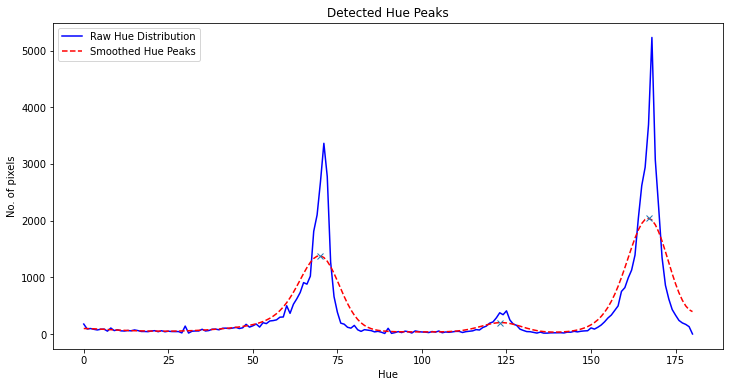

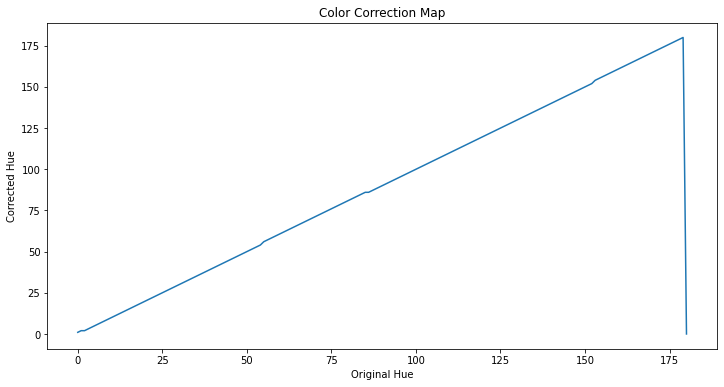

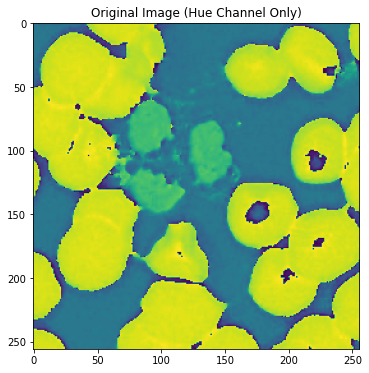

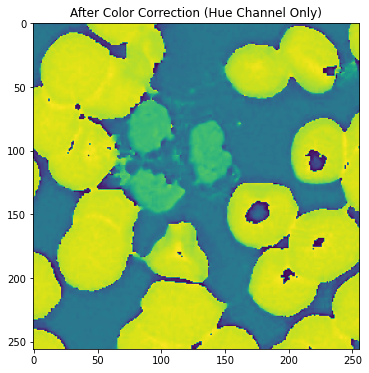

In [ ]:
#Merging WBC and Background class using chroma correction due to rarity of WBC
plt.figure(figsize=(12,6))
plt.title("Detected Hue Peaks")
plt.plot(histogram, "b", label="Raw Hue Distribution")
plt.plot(smoothedHistogram, "r--", label="Smoothed Hue Peaks")
plt.plot(peaksIndices, smoothedHistogram[peaksIndices], "x")
plt.xlabel("Hue")
plt.ylabel("No. of pixels")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.title("Color Correction Map")
plt.xlabel("Original Hue")
plt.ylabel("Corrected Hue")
plt.plot(colorCorrectionMap)
plt.show()

hueOnly = skewedColorImg[:,:,0]
plt.figure(figsize=(12,6))
plt.title("Original Image (Hue Channel Only)")
plt.imshow(hueOnly)
plt.show()

plt.figure(figsize=(12,6))
plt.title("After Color Correction (Hue Channel Only)")
plt.imshow(correctedImage[:,:,0])
plt.show()

# Pixel Classification using NBC

With the image-color variation issue settled, the NBC can then be applied to each colour-corrected image to mark each pixel as potential red blood cells. The translucency of the nuclei tends to result in a false negative within that region, resulting in "holes" present in the cell. 

If these "holes" are unaddressed, applying the distance transform later will incorrectly generate too many local maxima around the holes, which results in over-segmentation of the cells. 

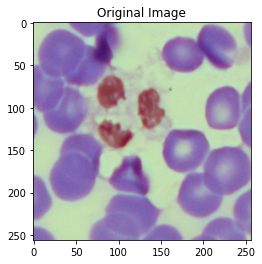

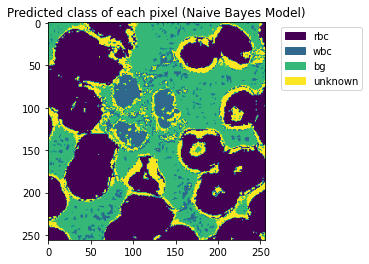

In [ ]:
#Applying Naive bayes classifier onto input images
def ApplyColorCorrectionToImage(hsvImage):
    histogram = GetHueHistogram(hsvImage)
    smoothedHistogram = gaussian_filter1d(histogram,5)
    
    expectedBGHue = 71 
    expectedRBCHue = 168 
    peaksIndices, _ = find_peaks(smoothedHistogram, distance=10)
    
    peakSearchWidth = 30
    detectedRBCPeak = GetClosestPeak(peaksIndices, expectedRBCHue, peakSearchWidth)
    detectedBGPeak = GetClosestPeak(peaksIndices, expectedBGHue, peakSearchWidth)
    
    colorCorrectionMap = GetHueCorrectionMap(expectedBGHue, detectedBGPeak, expectedRBCHue, detectedRBCPeak, peakSearchWidth)
    correctedImage = ApplyColourCorrectionMap(hsvImage, colorCorrectionMap)
    return correctedImage

colourCorrectedExample = ApplyColorCorrectionToImage(skewedColorImg)
ccMarkedPixels = CrudePixelClassification(colourCorrectedExample)
PlotMarkedPixelGraph(ccMarkedPixels, colourCorrectedExample)

# Filling of Small holes caused by poor Nuclei classification + Distance Transform

Since this classification problem only involves 2 classes (non RBC & RBC), the 3 non-RBC classes (White-Blood Cells, Background & Unknown) are lumped together into a single non-RBC class.

A median filter is first run on this new mask to remove noise. Holes are identified as regions of connected non-RBC pixels that are under a specified height & width. These are removed by flood-filling them with the markers for RBCs.

The distance transform is then taken to identify the "innermost" pixels within each region. These innermost regions are taken as the starting points (basins) for the watershed algorithm.

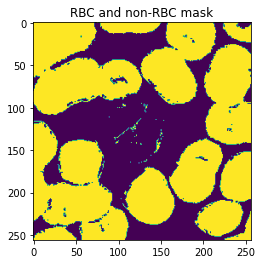

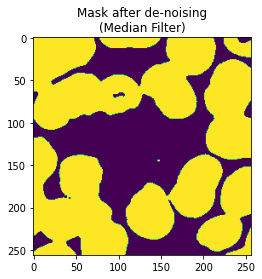

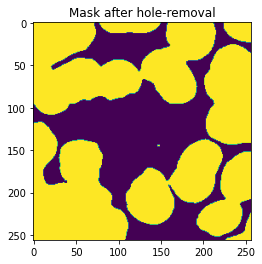

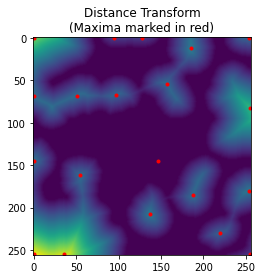

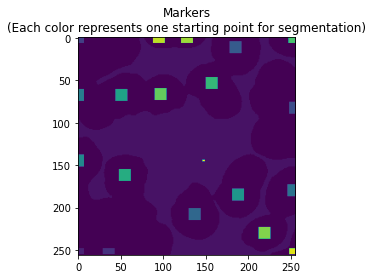

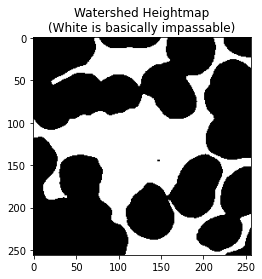

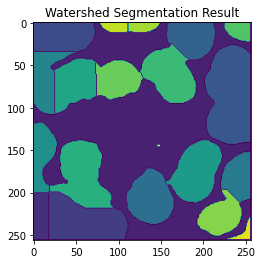

[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [ ]:
#Applying distance transform onto the images to enhnace the image and to address problem caused by transperancy of nuclie
from skimage.feature import peak_local_max
import math

def FilterOutLabel(inputImage, targetLabel):
    return np.equal(inputImage,targetLabel).astype(np.uint8)

def MedianFilter(inputImage):
    medBlurred = cv.medianBlur(inputImage, 7) 
    #kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7,7))
    #return  cv.morphologyEx(medBlurred, cv.MORPH_CLOSE, kernel, iterations=2)
    return medBlurred

def DistanceMapToNonRBCLabel(inputImage):
    return cv.distanceTransform(inputImage,cv.DIST_L2,3)

def DrawMarkerSeeds(cellMask, cellLabelWithinMask, markerList):
    markerBuffer = np.zeros(distanceTransform.shape, dtype=np.int32)
    for idx,coord in enumerate(markerList):
        (height,width) = cellMask.shape
        (maxRow, maxCol) = (height-1, width - 1)
        [row,col] = coord
        radius = 7 #cv.watershed seems to merge clusters together if the region seed is too small
        markerIdx = idx + 2 #0 reserved for indeterminate regions, 1 reserved for BG
        markerBuffer[max(row-radius,0):min(row+radius,maxRow),max(col-radius,0):min(col+radius,maxCol)] = markerIdx
        
    markerBuffer[cellMask==cellLabelWithinMask] = 1 #Give BG its own marker
    return markerBuffer

# 1 = perfectly spherical, numbers closer to 0 = less spherical
def Sphericity(width, height, area):
    diameter = max(width,height)
    expectedArea = 0.25 * math.pi * (diameter ** 2)
    sphericity = 1 - abs(expectedArea - area) / expectedArea
    return sphericity

def FillHolesInMask(maskImg, maxHoleSize, fillLabel):
    (_,labels,statList, _) = cv.connectedComponentsWithStats(np.max(maskImg)-maskImg, connectivity=8) 
    filledBuffer = np.copy(maskImg)
    for label,stats in enumerate(statList):
        (x,y,width,height,area) = stats
        isNuclei = Sphericity(width, height, area) > 0.3
        if (width <= maxHoleSize) and (height <= maxHoleSize) and isNuclei:
            filledBuffer[labels==label] = fillLabel
    return filledBuffer
    
rbcLabelsOnly = FilterOutLabel(markedPixels, 0)
plt.title("RBC and non-RBC mask")
plt.imshow(rbcLabelsOnly)
plt.show()

rbcSmoothed = MedianFilter(rbcLabelsOnly)
plt.title("Mask after de-noising\n(Median Filter)")
plt.imshow(rbcSmoothed)
plt.show()

rbcHolesRemoved = FillHolesInMask(rbcSmoothed, 40, 1)
plt.title("Mask after hole-removal")
plt.imshow(rbcHolesRemoved)
plt.show()

distanceTransform = DistanceMapToNonRBCLabel(rbcHolesRemoved)
localMaximaCoordinates = peak_local_max(distanceTransform,exclude_border=False, min_distance=22)
plt.title("Distance Transform\n(Maxima marked in red)")
plt.imshow(distanceTransform)
plt.plot(localMaximaCoordinates[:,1], localMaximaCoordinates[:,0], 'r.')
plt.show()

markers = DrawMarkerSeeds(rbcHolesRemoved, 0, localMaximaCoordinates)

plt.title("Markers\n(Each color represents one starting point for segmentation)")
plt.imshow(markers)
plt.show()

_3ChannelGrayscale = cv.cvtColor(255 - rbcHolesRemoved*255, cv.COLOR_GRAY2BGR).astype(np.uint8)
plt.title("Watershed Heightmap\n(White is basically impassable)")
plt.imshow(_3ChannelGrayscale)
plt.show()


segmented = cv.watershed(_3ChannelGrayscale, markers)
plt.title("Watershed Segmentation Result")
plt.imshow(segmented)
plt.show()
print(np.unique(segmented))

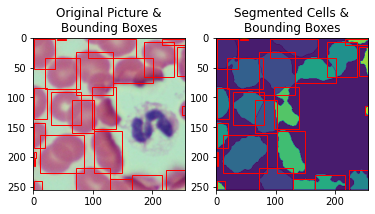

In [ ]:
#Adding bounding boxes to the segmented image
from matplotlib.patches import Rectangle

#(hsvImage:HSV image) => (segmentedImage:int32[][]  - -1 for watershed boundaries, 1 for bg, +ve integers represent label for connected components) 
def SegmentImage(hsvImage):
    classifiedPixels = CrudePixelClassification(hsvImage)
    rbcOnly = FilterOutLabel(classifiedPixels, 0)
    rbcDenoised = MedianFilter(rbcOnly)
    rbcHolesRemoved = FillHolesInMask(rbcDenoised, 40, 1)
    distanceTransform = DistanceMapToNonRBCLabel(rbcHolesRemoved)
    
    localMaximaCoordinates = peak_local_max(distanceTransform,exclude_border=False, min_distance=10)
    markerSeeds = DrawMarkerSeeds(rbcHolesRemoved, 0, localMaximaCoordinates)
    
    bgrGrayscaleHeightMap =  cv.cvtColor(255 - rbcHolesRemoved*255, cv.COLOR_GRAY2BGR).astype(np.uint8)
    segmentedCells = cv.watershed(bgrGrayscaleHeightMap, markerSeeds)
    return segmentedCells 

#type = ['rbc'|'wbc']
#CellLabel = namedtuple('CellLabel', ['left', 'top', 'right', 'bot', 'type'])

def GetCellBoundingBoxes(segmentedImage):
    allLabels = np.unique(segmentedImage)
    cellLabels = allLabels[allLabels > 1]
    boundingBoxList = []
    for cellLabel in cellLabels:
        cellMask = np.equal(segmentedImage, cellLabel).astype(np.uint8) #inefficient, but probably still faster than a BFS in python
        rect = cv.boundingRect(cellMask)
        boundingBoxList.append(CellLabel(rect[0], rect[1], rect[0] + rect[2], rect[1] + rect[3], "rbc"))
    return boundingBoxList

def PlotSegmentedImageAndBoundingBoxes(segmentedImg, boundingBoxList, hsvImage):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(cv.cvtColor(hsvImage, cv.COLOR_HSV2RGB))
    ax1.set_title("Original Picture &\nBounding Boxes")
    ax2.imshow(segmentedImg)
    ax2.set_title("Segmented Cells &\nBounding Boxes")
    for boundingBox in boundingBoxList:
        (width, height) = (boundingBox.right - boundingBox.left, boundingBox.bot - boundingBox.top)
        ax1.add_patch(Rectangle((boundingBox.left, boundingBox.top), width, height, color="red",fill=None))
        ax2.add_patch(Rectangle((boundingBox.left, boundingBox.top), width, height, color="red",fill=None))
    plt.show()
        
testImg = trainImgList[6]         
segmentedImg = SegmentImage(testImg)
boundingBoxes = GetCellBoundingBoxes(segmentedImg)
PlotSegmentedImageAndBoundingBoxes(segmentedImg, boundingBoxes, testImg)

In [ ]:
from multiprocessing import Pool

print(len(trainImgList))

def ProcSegment(hsvImage):
    colorCorrected = ApplyColorCorrectionToImage(hsvImage)
    segmented = SegmentImage(colorCorrected)
    boundingBoxes = GetCellBoundingBoxes(segmented)
    return (segmented, boundingBoxes)

#(segmentationMap:int32[][], boundingBoxes:CellLabels[])[]
cellSegmentations = []


70


In [ ]:
with Pool() as processPool:
    cellSegmentations = processPool.map(ProcSegment, trainImgList)

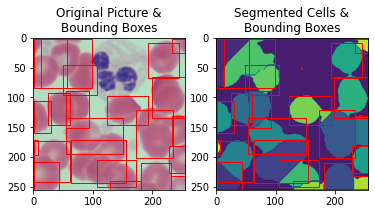

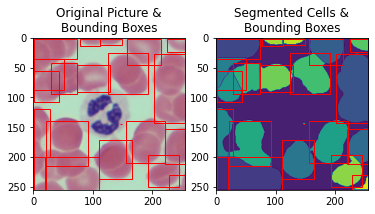

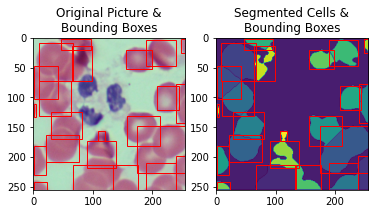

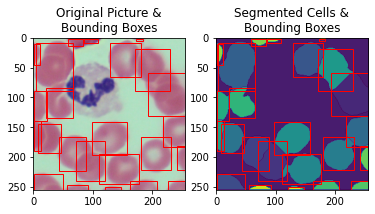

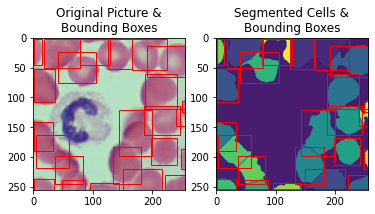

In [ ]:
for cellSegmentationData,hsvImg in list(zip(cellSegmentations,trainImgList))[0:5]:
    (segmentation, boundingBoxes) = cellSegmentationData
    PlotSegmentedImageAndBoundingBoxes(segmentation, boundingBoxes, hsvImg)

# Evaluation Metrics

Intersection-Over-Union is a simple metric that describes how closely two regions overlap. It is the ratio of the area of the overlapping regions and the combined area of of the regions. An IOU of 1 represents a perfect match, where as an IOU of 0 represents no overlap at all. Due to the denominator being the combined area of both regions, this metric also penalizes predictions that are excessively large in comparison to the ground truth.

Due to the nature of the Watershed Algorithm, the number of predicted Red-blood cells may not match with the ground truth. As such, deciding which predictions & ground truth pairs to calculate the IOU with becomes an open question.
To achieve the global optimal pairing of ground-truths & predictions based on their distances, a min-weight bipartitate match is deployed. Bounding boxes with no available match are simply ignored.

In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import min_weight_full_bipartite_matching

def CellLabelCentre(cellLabel):
    xCentre = 0.5 * (cellLabel.right + cellLabel.left)
    yCentre = 0.5 * (cellLabel.top + cellLabel.bot)
    return (xCentre, yCentre)

def EuclideanDist(coord1, coord2):
    return math.hypot(coord1[0] - coord2[0], (coord1[1] - coord2[1]))

def GetCellBoundingBoxArea(cellLabel):
    width = cellLabel.right -  cellLabel.left
    height = cellLabel.bot - cellLabel.top 
    return width * height

def GetIOU(cellLabel1, cellLabel2):
    def SafeDiv(numerator, denominator):
        if numerator == 0 and denominator == 0:
            return 0
        elif denominator == 0:
            return sys.float_info.max
        else:
            return numerator / denominator
    
    def Overlap(min1, max1, min2, max2):
        return max(0, min(max1, max2) - max(min1, min2))
    
    xIntersection = Overlap(cellLabel1.left, cellLabel1.right, cellLabel2.left, cellLabel2.right)
    yIntersection = Overlap(cellLabel1.top, cellLabel1.bot, cellLabel2.top, cellLabel2.bot)
    
    intersectionArea = xIntersection * yIntersection
    unionArea = GetCellBoundingBoxArea(cellLabel1) +  GetCellBoundingBoxArea(cellLabel2) - intersectionArea
    
    #IOU ranges from 0-1
    return max(SafeDiv(intersectionArea, unionArea), 0)
    

#CellLabel = namedtuple('CellLabel', ['left', 'top', 'right', 'bot', 'type'])
def GetIOUScore(groundTruth, predictions):
    groundTruthCentres = [CellLabelCentre(label) for label in groundTruth]
    predictionCentres = [CellLabelCentre(label) for label in predictions]
    #groundTruth -> prediction
    #adjGraph[groundTruthIdx][predictedIndex] -> distance
    adjGraph = []
    for srcPoint in groundTruthCentres:
        #add one to cater to the min-weight bipartite matching algorithm
        distances = [EuclideanDist(srcPoint, destPoint) + 1 for destPoint in predictionCentres]
        adjGraph.append(distances)
    biadjacency_matrix = csr_matrix(adjGraph)
    groundTruth_ind, prediction_ind = min_weight_full_bipartite_matching(biadjacency_matrix)
    
    matchedGroundTruthLabels = [groundTruth[index] for index in groundTruth_ind]
    matchedPredictedLabels = [predictions[index] for index in prediction_ind]
    
    iouScoreList = []
    
    for actual, predicted in zip(matchedGroundTruthLabels, matchedPredictedLabels):
        iou = GetIOU(actual, predicted)
        iouScoreList.append((iou, actual, predicted))
    
    #no penalty applied for false positives / unidentified cells
    meanIOU = (
        np.mean([iou for iou,_,_ in iouScoreList]) 
        if len(iouScoreList) > 0 
        else 0)
    
    return (meanIOU, iouScoreList)

In [ ]:
#list for each image
trainCellLabelsList = [imgLabelDict[filename] for filename in trainSampleFilenames]
predictedTrainCellLabelsList = [cellLabel for _, cellLabel in cellSegmentations]

imgMeanAndMatches = []
for imgLabel, imgPredictions in zip(trainCellLabelsList, predictedTrainCellLabelsList):
    mean, matchedPredictionList = GetIOUScore(imgLabel, imgPredictions)
    imgMeanAndMatches.append((mean, matchedPredictionList))

means = [mean for mean, _ in imgMeanAndMatches]
print("Mean of mean IOUs:{:.2f}%".format(np.mean(means) * 100))

Mean of mean IOUs:58.07%


## Segmentation results on Test Image set

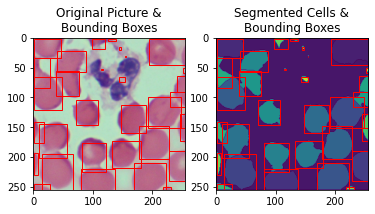

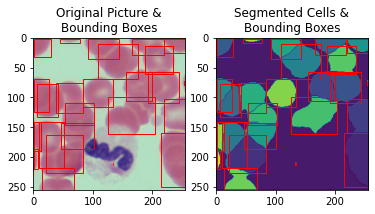

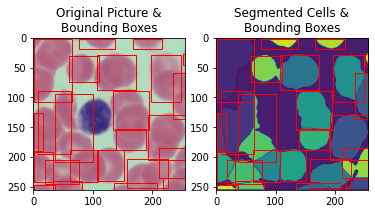

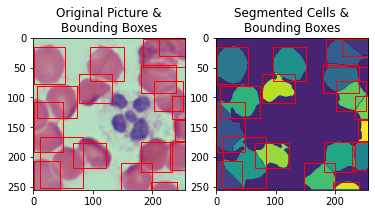

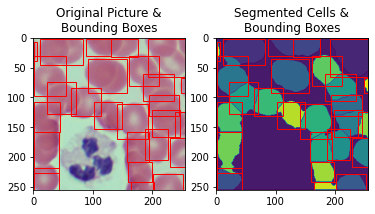

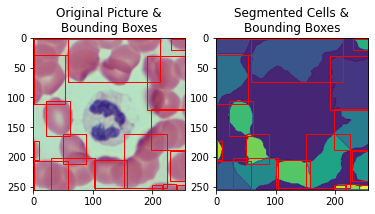

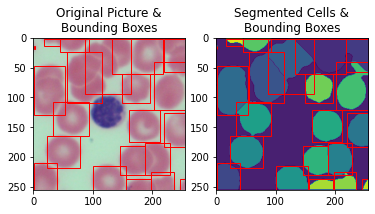

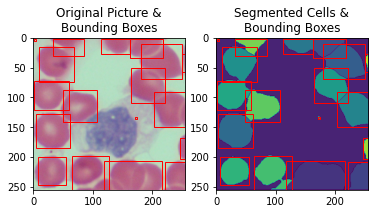

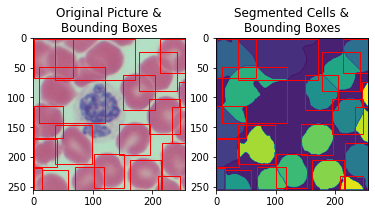

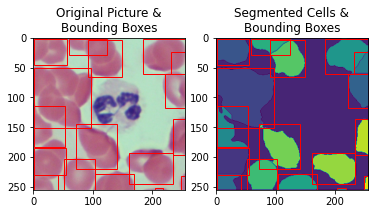

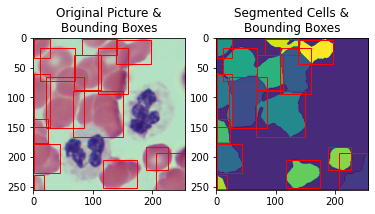

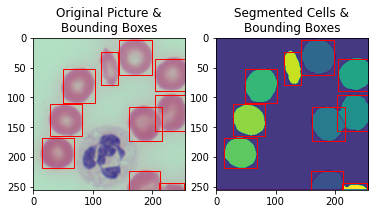

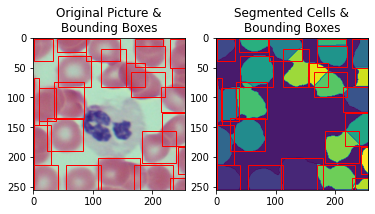

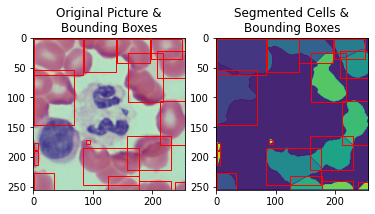

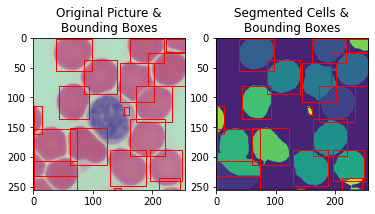

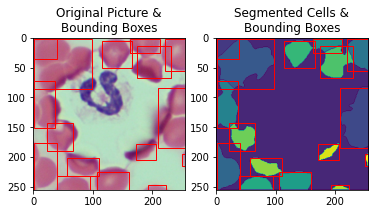

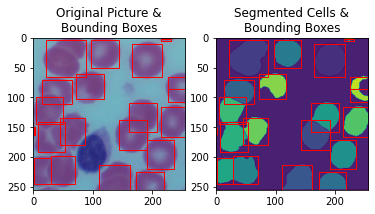

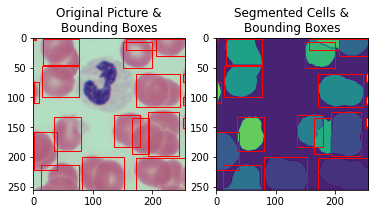

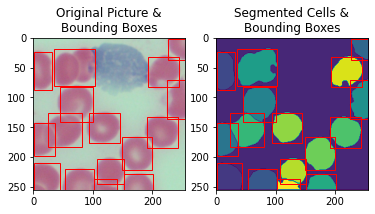

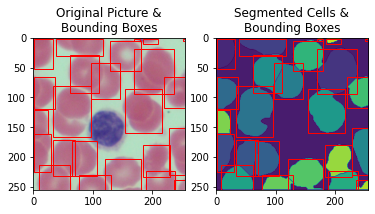

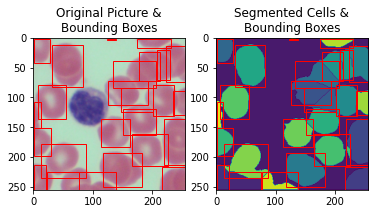

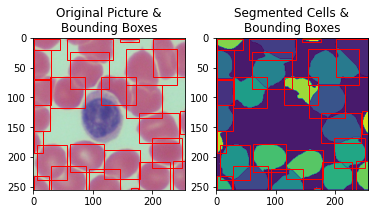

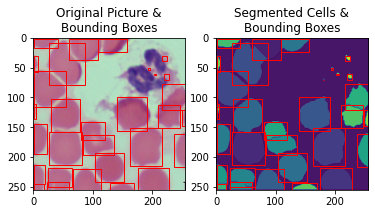

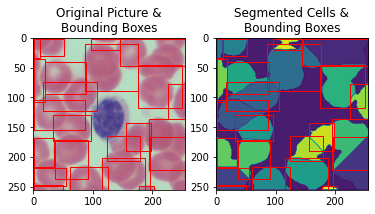

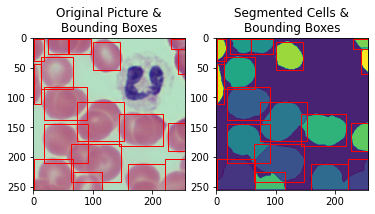

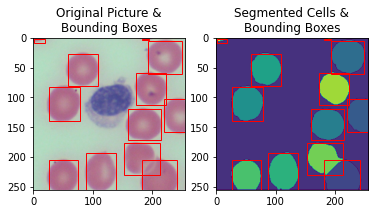

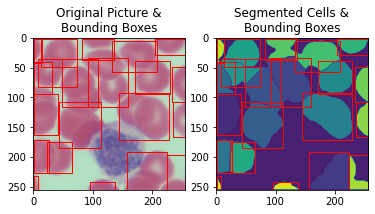

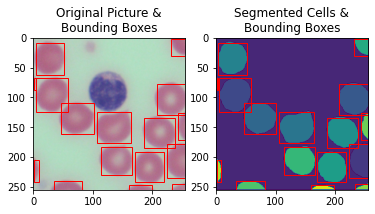

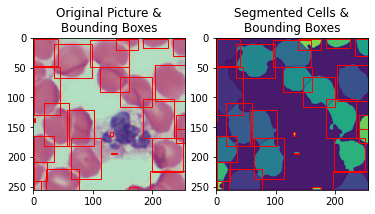

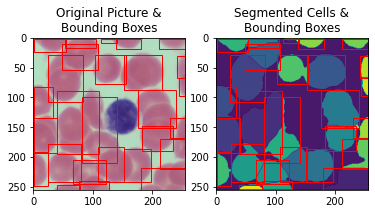

In [ ]:
testImgList = [imgDict[path] for path in testSampleFilenames]

testSetSegmentations = []

with Pool() as processPool:
    testSetSegmentations = processPool.map(ProcSegment, testImgList)
    
for cellSegmentationData,hsvImg in list(zip(testSetSegmentations,testImgList)):
    (segmentation, boundingBoxes) = cellSegmentationData
    PlotSegmentedImageAndBoundingBoxes(segmentation, boundingBoxes, hsvImg)

# Test Image Set IOU results

The IOUs produced by the watershed approach follow a bimodal distribution. A significant fraction (13%) fail to create any significant overlap with the ground truth (< 0.2 IOU score) and can simply be interpreted as misidentified Red-Blood Cells.

The second peak in the Bimodal distribution (>= 0.2 IOU) has a mean of 0.72, and can be construed as the accuracy when running Watershed Segmentation on correctly identified RBC regions.

Given that misclassification of regions as RBC appears to be an issue, more sophisticated methods to perform the preliminary pixel classification could be used (i.e. Grabcut to iterately refine the red-blood cell regions) if higher accuracy is required.

Mean IOU for matched bounding boxes 60.57%
No. of ground truth bounding boxes: 700,
No. of predicted bounding boxes: 622
No. of matched bounding boxes: 593
---
Size of node1:71, mean=0.02
Size of node2:522, mean=0.69, median=0.72


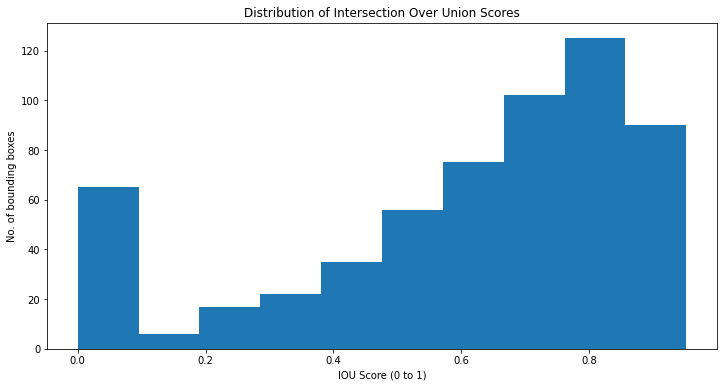

In [ ]:
#list for each image
testCellLabelsList = [imgLabelDict[filename] for filename in testSampleFilenames]
predictedTestCellLabelsList = [cellLabel for _, cellLabel in testSetSegmentations]

matchedIOUs = []

for imgLabel, imgPredictions in zip(testCellLabelsList, predictedTestCellLabelsList):
    mean, matchedPredictionList = GetIOUScore(imgLabel, imgPredictions)
    iousOnly =  [iou for (iou,_,_) in matchedPredictionList]
    matchedIOUs.extend(iousOnly) 

nMatchedLabels = len(matchedIOUs)
nGroundTruthLabels = np.sum([len(labelList) for labelList in testCellLabelsList])
nPredictedLabels = np.sum([len(labelList) for labelList in predictedTestCellLabelsList])


print("Mean IOU for matched bounding boxes {:.2f}%".format(np.mean(matchedIOUs) * 100))
print("No. of ground truth bounding boxes: {0},\nNo. of predicted bounding boxes: {1}\nNo. of matched bounding boxes: {2}".format(nGroundTruthLabels, nPredictedLabels, nMatchedLabels))

print("---")
node1 = [iou for iou in matchedIOUs if iou < 0.2]
node2 = [iou for iou in matchedIOUs if iou >= 0.2]
print("Size of node1:{}, mean={:.2f}\nSize of node2:{}, mean={:.2f}, median={:.2f}".format(len(node1), np.mean(node1), len(node2), np.mean(node2), np.median(node2)))

plt.figure(figsize=(12,6))
plt.title("Distribution of Intersection Over Union Scores")
plt.ylabel("No. of bounding boxes")
plt.xlabel("IOU Score (0 to 1)")
plt.hist(matchedIOUs)
plt.show()